In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load data
transactions = pd.read_csv(r"C:\Users\user\Desktop\transactions.csv")
customers = pd.read_csv(r"C:\Users\user\Desktop\customers.csv")


MAE: 200.00, RMSE: 200.00


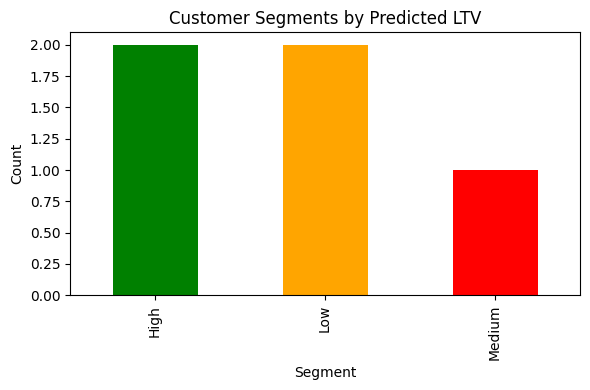

In [2]:
# Clean column names
transactions.columns = transactions.columns.str.strip()
customers.columns = customers.columns.str.strip()

# Merge on CustomerID
df = transactions.merge(customers, on='CustomerID', how='left')

# Convert date column
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Reference date for Recency
reference_date = df['TransactionDate'].max()

# Feature engineering
features = df.groupby('CustomerID').agg({
    'TransactionDate': [lambda x: (reference_date - x.max()).days, 'count'],
    'TransactionAmount': 'mean'
})
features.columns = ['Recency', 'Frequency', 'AOV']
features = features.reset_index()

# Target: total LTV
df_ltv = df.groupby('CustomerID')['TransactionAmount'].sum().reset_index()
df_ltv.columns = ['CustomerID', 'LTV']

# Final dataset
final_df = features.merge(df_ltv, on='CustomerID')

# Prepare training data
X = final_df[['Recency', 'Frequency', 'AOV']]
y = final_df['LTV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Save model
with open("ltv_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Predict LTV for all
final_df['Predicted_LTV'] = model.predict(scaler.transform(X))

# Segment customers
q50 = final_df['Predicted_LTV'].quantile(0.5)
q75 = final_df['Predicted_LTV'].quantile(0.75)
final_df['LTV_Segment'] = final_df['Predicted_LTV'].apply(
    lambda x: 'High' if x >= q75 else ('Medium' if x >= q50 else 'Low')
)

# Save predictions
final_df.to_csv("ltv_predictions.csv", index=False)

# Plot segments
plt.figure(figsize=(6,4))
final_df['LTV_Segment'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Customer Segments by Predicted LTV")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("ltv_segments_plot.png")
plt.show()
